In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
from RaTag.scripts.crystalball_fitter import *
from RaTag.scripts.alpha_spectrum_simulator import *
from RaTag.scripts.unit_conversion import *

# Model peak as Crystalball

In [3]:
ROOT_PATH = '/Users/pabloherrero/sabat/RaTagging/RaTag/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air.csv'

# Initialize the spectrum calibrator with the file
sc = SpectrumCalibrator(file_spectrum)
nuclides = sc.run()

# Get the spectrum in energy scale
energies, counts = sc.get_energy_spectrum()
df_energy = pd.DataFrame({'energy': energies, 'counts': counts})

[Text(0.5, 1.0, 'CrystalBall Fit of Po-216 Peak')]

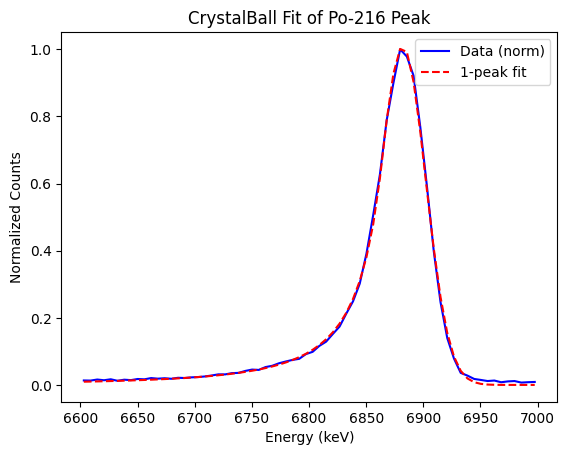

In [4]:
# Fit the Po-216 peak using the CrystalBallFitter
fitter = CrystalBallFitter(df_energy)
fitter.select_roi(cutdown=6600, cutup=7000)
res_cb = fitter.fit()
fig, ax = plt.subplots()
fitter.plot_fit(ax)
plt.gca().set(title='CrystalBall Fit of Po-216 Peak')

# Simulate Th-228 and Ra-224 decays with main BR

In [5]:
simulation_ThRa, spectrum_ThRa = simulate_Th_Ra(res_cb,  N=1_000_000)

Th228_5423keV: 722000 events
Th228_5340keV: 150000 events
Ra224_5686keV: 722000 events
Ra224_5449keV: 38000 events


<Axes: title={'center': 'Decay Spectra'}, xlabel='Energy (keV)', ylabel='Normalized Counts'>

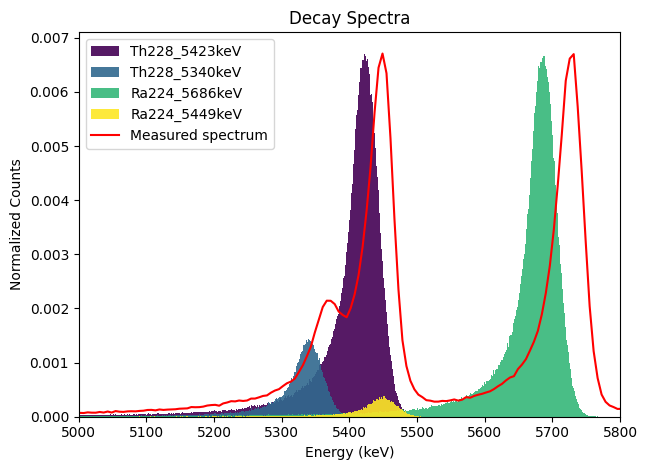

In [6]:
fig, ax = plt.subplots()
norm_factor, ax = plot_Th_Ra_simulation(simulation_ThRa, cutdown=5000, cutup=5800, ax=ax)
plot_normalized_spectrum(df_energy, norm_factor, ax=ax)

<Axes: title={'center': 'Decay Spectrum Simulation'}, xlabel='Energy (keV)', ylabel='Normalized Counts'>

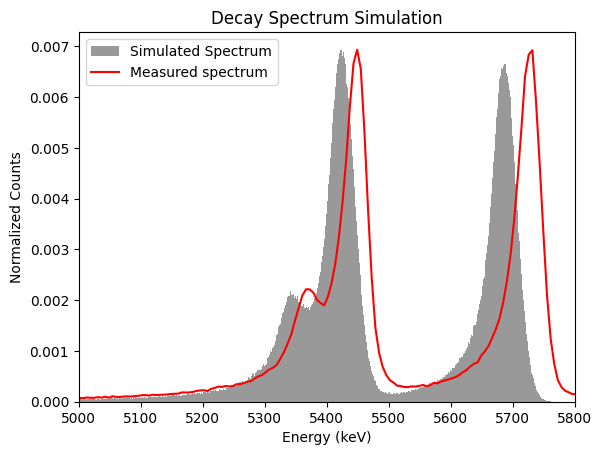

In [7]:
fig, ax = plt.subplots()
norm_factor, ax = plot_simulation_full_spectrum(spectrum_ThRa, cutdown=5000, cutup=5800, ax=ax)
plot_normalized_spectrum(df_energy, norm_factor, ax=ax)

# Define SNR as function of energy cut

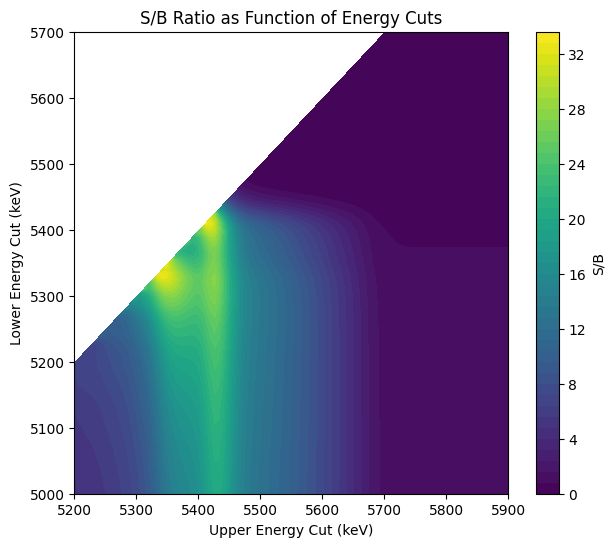

In [ ]:
E_low_range = np.linspace(5000, 5700, 100)
E_high_range = np.linspace(5200, 5900, 100)
S_over_B, ax = contour_plot_SB_ratio(E_low_range, E_high_range, simulation_ThRa, ax=None)

(np.int64(27), np.float64(24.11709533536204))

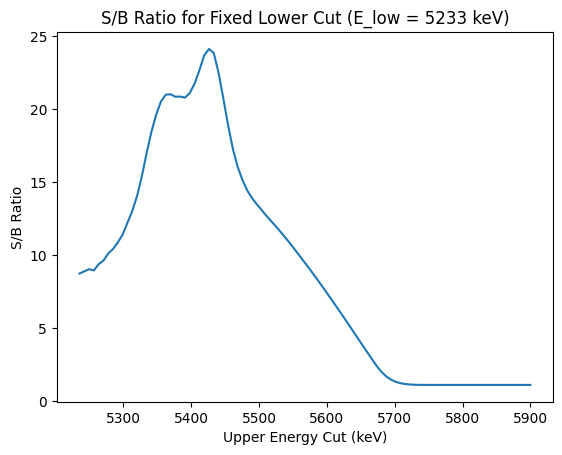

In [87]:
# Plot S/B ratio for a fixed lower cut
E_low_fixed = 5233  # Example fixed lower cut
S_over_B_fixed = S_over_B[33, :]
fig, ax = plt.subplots()
ax.plot(E_high_range, S_over_B_fixed)
ax.set(title='S/B Ratio for Fixed Lower Cut (E_low = 5233 keV)',
       xlabel='Upper Energy Cut (keV)', ylabel='S/B Ratio')
np.argmax(S_over_B_fixed[S_over_B_fixed > 0]), np.max(S_over_B_fixed[S_over_B_fixed > 0])

In [88]:
E_high_range[S_over_B_fixed > 0][np.argmax(S_over_B_fixed[S_over_B_fixed > 0])]

np.float64(5426.262626262626)

(np.int64(45), np.float64(24.91106120157215))

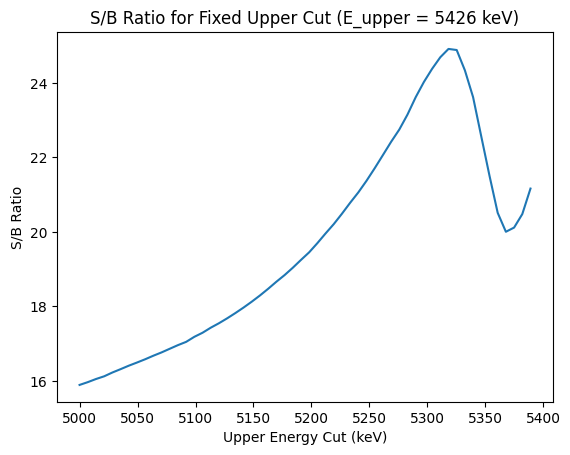

In [89]:
# Plot S/B ratio for a fixed upper cut
E_upper_fixed = 5426  # Example fixed upper cut
S_over_B_fixed = S_over_B[:, 27]
fig, ax = plt.subplots()
ax.plot(E_low_range, S_over_B_fixed)
ax.set(title=f'S/B Ratio for Fixed Upper Cut (E_upper = {E_upper_fixed} keV)',
       xlabel='Upper Energy Cut (keV)', ylabel='S/B Ratio')
np.argmax(S_over_B_fixed[S_over_B_fixed > 0]), np.max(S_over_B_fixed[S_over_B_fixed > 0])

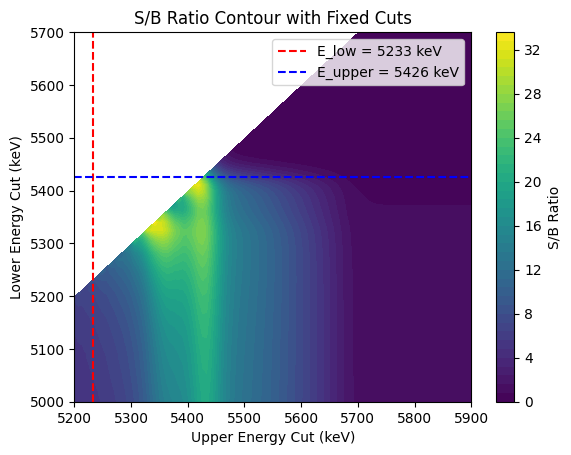

In [93]:
plt.contourf(E_high_range, E_low_range, S_over_B, levels=50, cmap='viridis')
plt.axvline(E_low_fixed, color='red', linestyle='--', label=f'E_low = {E_low_fixed} keV')
plt.axhline(E_upper_fixed, color='blue', linestyle='--', label=f'E_upper = {E_upper_fixed} keV')
plt.colorbar(label='S/B Ratio')
plt.gca().set(title='S/B Ratio Contour with Fixed Cuts',
              xlabel='Upper Energy Cut (keV)', ylabel='Lower Energy Cut (keV)')
plt.legend()

# Average resolution

In [34]:
decays0 = sorted(results_ThRa['Ra224_5449keV'])
decays0 = np.array(decays0)
resolution = decays0[1:] - decays0[:-1]
print(f"Average resolution: {np.mean(resolution):.2f} keV")

Average resolution: 1.49 keV


## Estimate Bg count rate

In [20]:
def get_background_rate(results, low_cut, high_cut):
    """
    Calculate the background rate in the specified energy range.
    """
    ra_vals = np.concatenate([results['Ra224_5686keV'], results['Ra224_5449keV']])
    n_ra_in_cut = np.count_nonzero((ra_vals >= low_cut) & (ra_vals <= high_cut))
    background_rate = n_ra_in_cut / sum(len(v) for v in results.values()) * 100
    # background_rate = fraction_of_ra / (high_cut - low_cut)  # Approximate rate per channel
    return background_rate

low_cut = 800
high_cut = cutup[np.argmax(snrs)]
background_rate = get_background_rate(results, low_cut, high_cut)
print(f"Background rate in range ({low_cut}, {high_cut}): {background_rate:.4f} percent")

Background rate in range (800, 968): 4.0865 percent


[Text(0.5, 0, 'Upper energy cut (channel)'),
 Text(0, 0.5, 'Bg rate (Ra / total events)'),
 Text(0.5, 1.0, 'Bg rate vs Upper Energy Cut')]

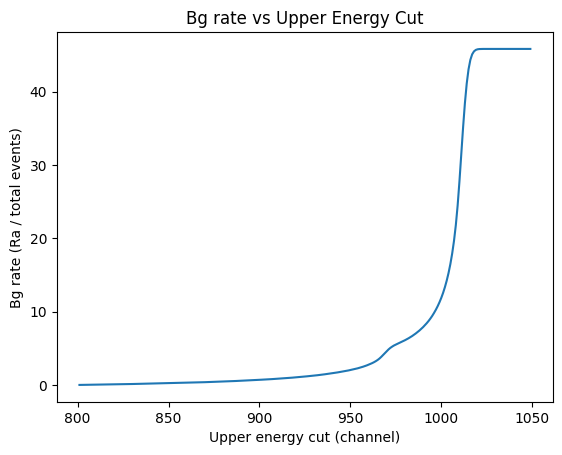

In [21]:
cutup = np.arange(801, 1050, 1)
bg_rates = [get_background_rate(results, cutdw, cu) for cu in cutup]
plt.plot(cutup, bg_rates)
plt.gca().set(xlabel = 'Upper energy cut (channel)', ylabel = 'Bg rate (Ra / total events)', title='Bg rate vs Upper Energy Cut')

## Transform to energy scale

In [36]:
beta = beta
m = m
scale = scale
# Define decay modes for Th-228 and Ra-224
modes = [
    DecayMode(name="Th228_5423keV", loc=5423.15, beta=beta, m=m, scale=scale, branching_ratio=0.722),
    DecayMode(name="Th228_5340keV", loc=5340.36, beta=beta, m=m, scale=scale, branching_ratio=0.278),
    DecayMode(name="Ra224_5686keV", loc=5685.37, beta=beta, m=m, scale=scale, branching_ratio=0.949),
    DecayMode(name="Ra224_5449keV", loc=5448.6, beta=beta, m=m, scale=scale, branching_ratio=0.051),]

simulator = SpectrumSimulator(modes)
results, spectrum = simulator.simulate(total_events=1_000_000)


Th228_5423keV: 722000 events
Th228_5340keV: 278000 events
Ra224_5686keV: 949000 events
Ra224_5449keV: 51000 events


[(5200.0, 5720.0)]

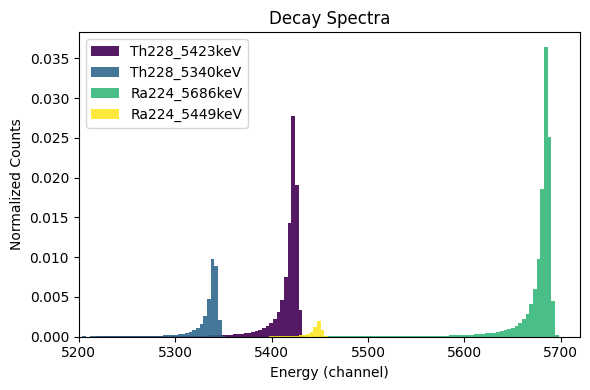

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
total_events = sum(len(v) for v in results.values())

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for i,k in enumerate(results):
    print(f"{k}: {len(results[k])} events")
    n, bins = histogram_decay(results[k], col=colors[i], bins=1000, ax=ax, label=k, total_events=total_events)
ax.legend()
plt.tight_layout()
plt.gca().set(xlim=(5200, 5720), )


## Transform to Voltage scale

In [ ]:
results_V = {}
for decay in simulation_ThRa.keys():
    positive_channels = simulation_ThRa[decay][simulation_ThRa[decay] > 0]
    decay_v = [*map(energy_to_voltage, positive_channels)]
    results_V[decay] = np.array(decay_v)
results_V

Th228_5423keV: 721463 events
Th228_5340keV: 149878 events
Ra224_5686keV: 721445 events
Ra224_5449keV: 37968 events


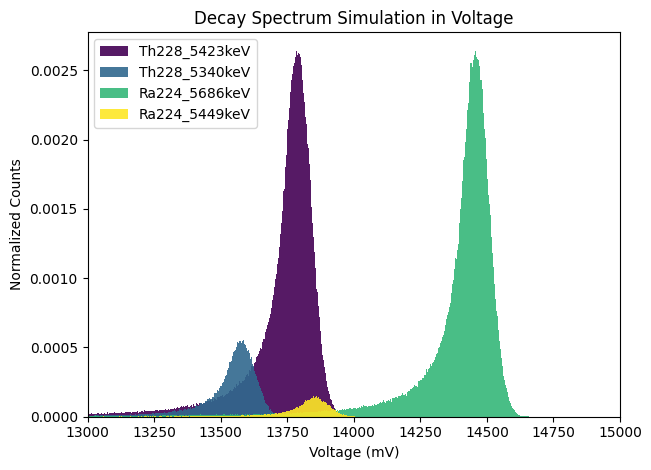

In [ ]:
plot_Th_Ra_simulation(results_V, cutdown=13000, cutup=15000)
plt.gca().set(xlabel='Voltage (mV)', ylabel='Normalized Counts', title='Decay Spectrum Simulation in Voltage')
plt.legend()